In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [16]:
from proj1_helpers import *
from implementations import *
import os
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'train.csv'
data_path = os.path.join(data_base_path, data_folder)
y, tX, ids = load_csv_data(data_path)

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [17]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


## Changing cv

In [18]:
tX = np.delete(tX, 22, axis=1)
tX, to_remove = missingness_filter(tX, 0.1)
tX = impute_median(tX)

In [19]:
print(tX.shape)
to_remove = np.append(to_remove, 22)
print(to_remove)

(250000, 18)
[ 0  4  5  6 12 22 23 24 25 26 27 22]


In [ ]:
y = np.where(y==-1, 0, y)

In [20]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-12, 0, 5)
degrees = range(1, 5)

k_indices = build_k_indices(y[0:10000,], k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y[0:10000,], tX[0:10000,:], k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=True)

Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5


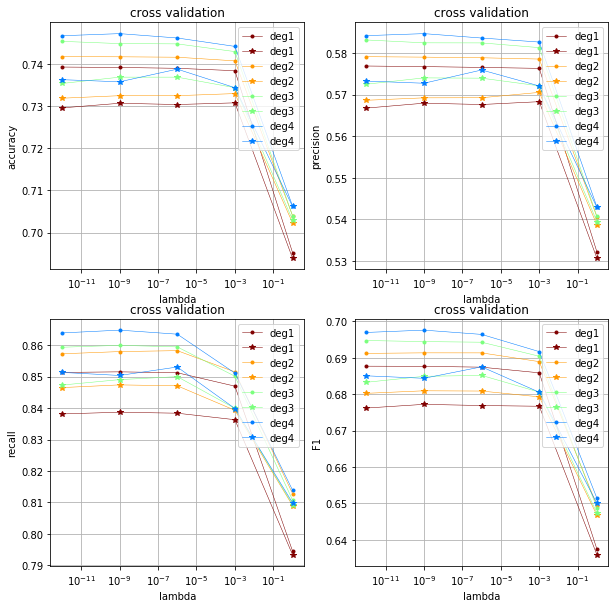

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
cross_validation_visualization(degrees, acc_measures["acc_tr"], acc_measures["acc_te"], lambdas, "accuracy")
plt.subplot(2, 2, 2)
cross_validation_visualization(degrees, acc_measures["pre_tr"], acc_measures["pre_te"], lambdas, "precision")
plt.subplot(2, 2, 3)
cross_validation_visualization(degrees, acc_measures["rec_tr"], acc_measures["rec_te"], lambdas, "recall")
plt.subplot(2, 2, 4)
cross_validation_visualization(degrees, acc_measures["f1_tr"], acc_measures["f1_te"], lambdas, "F1")

In [ ]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-12, 0, 5)
degrees = range(1, 5)

k_indices = build_k_indices(y[0:10000,], k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y[0:10000,], tX[0:10000,:], k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'lr', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=False)

In [ ]:
def vis_cv_acc(degrees,lambdas,acc_measures):
    plt.figure(figsize=(10,10))
    plt.subplot(2, 2, 1)
    cross_validation_visualization(degrees, acc_measures["acc_tr"], acc_measures["acc_te"], lambdas, "accuracy")
    plt.subplot(2, 2, 2)
    cross_validation_visualization(degrees, acc_measures["pre_tr"], acc_measures["pre_te"], lambdas, "precision")
    plt.subplot(2, 2, 3)
    cross_validation_visualization(degrees, acc_measures["rec_tr"], acc_measures["rec_te"], lambdas, "recall")
    plt.subplot(2, 2, 4)
    cross_validation_visualization(degrees, acc_measures["f1_tr"], acc_measures["f1_te"], lambdas, "F1")

In [ ]:
vis_cv_acc(degrees,lambdas,acc_measures)

In [ ]:
lambdas = np.logspace(-9, -3, 7)
print(lambdas)

## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)